### Setup/Imports

In [1]:
import os
import gc
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
import pandas as pd
import scipy.io
from pipeline.paths import Directories, Files
from pipeline.utils import read_scans_agg_file

### Config

In [2]:
PHASE = "7"
DATA_VERSION = "13"

# Parameters for each model dictionary:
#   'name': A custom name for plotting and tables (e.g., "Ensemble", "MC Dropout").
#   'type': The type of model. Options:
#           'ensemble': For a collection of deterministically trained models.
#           'stochastic': For a single model that requires multiple forward passes (e.g., MC Dropout, BBB).
#   'domain': The domain to analyze. Options: 'PROJ', 'FDK', 'IMAG'.
#           'PROJ': For projection domain analysis (after PD model).
#           'FDK': For FDK reconstruction analysis (between PD and ID models).
#           'IMAG': For image domain analysis (after ID model).
#   'model_version_root': The base name of the model version.
#                         For ensembles, this is the name without the '_XX' suffix.
#                         For stochastic models, this is the full model version name.
#   'count': The number of models in the ensemble or the number of stochastic passes.

MODELS_TO_ANALYZE = [
    # {
    #     'name': 'Ensemble',
    #     'type': 'ensemble',
    #     'domain': 'IMAG',
    #     'model_version_root': 'MK7',
    #     'count': 1,
    # },
    {
        'name' : 'SWAG 0.01 LAST 2',
        "type" : 'stochastic',
        'domain': 'IMAG',
        'model_version_root': 'MK7_SWAG_1e-2_ONLY_LAST2',
        'count' : 10,
    },
    {
        'name' : 'SWAG 0.1 LAST 2',
        "type" : 'stochastic',
        'domain': 'IMAG',
        'model_version_root': 'MK7_SWAG_1e-1_ONLY_LAST2',
        'count' : 10,
    },
    {
        'name' : 'SWAG 0.01',
        "type" : 'stochastic',
        'domain': 'IMAG',
        'model_version_root': 'MK7_SWAG_1e-2',
        'count' : 20,
    },
    {
        'name' : 'SWAG 0.1',
        "type" : 'stochastic',
        'domain': 'IMAG',
        'model_version_root': 'MK7_SWAG_1e-1',
        'count' : 20,
    },
    # {
    #     'name': 'MC Dropout 30%',
    #     'type': 'stochastic',
    #     'domain': 'PROJ',
    #     'model_version_root': 'MK7_MCDROPOUT_30_pct_NEW',
    #     'count': 10,
    # },
    # {
    #     'name': 'MC Dropout 50%',
    #     'type': 'stochastic',
    #     'domain': 'PROJ',
    #     'model_version_root': 'MK7_MCDROPOUT_50_pct_NEW',
    #     'count': 10,
    # },
]

WORK_ROOT = "D:/NoahSilverberg/ngCBCT"
SCANS_AGG_FILE = 'scans_to_agg.txt'
SPLIT_TO_ANALYZE = 'VALIDATION' # Options: 'TRAIN', 'VALIDATION', 'TEST'

SLICE_IDX = 100 # TODO: add tumor slice option for FDK and IMAG domains

# Create Directories and Files objects
phase_dataver_dir = os.path.join(WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}")
DIRECTORIES = Directories(
    projections_results_dir=os.path.join(phase_dataver_dir, "results", "projections"),
    projections_gated_dir=os.path.join(WORK_ROOT, "gated", "prj_mat"),
    reconstructions_dir=os.path.join(phase_dataver_dir, "reconstructions"),
    reconstructions_gated_dir=os.path.join(WORK_ROOT, "gated", "fdk_recon"),
    images_results_dir=os.path.join(phase_dataver_dir, "results", "images"),
)
FILES = Files(DIRECTORIES)

# Load the list of scans
scans_agg, scan_type_agg = read_scans_agg_file(SCANS_AGG_FILE)
analysis_scans = scans_agg[SPLIT_TO_ANALYZE][:2] # TODO delete

print(f"Configuration loaded.")
print(f"Analyzing {len(analysis_scans)} scans from the '{SPLIT_TO_ANALYZE}' split.")
print(f"Found {len(MODELS_TO_ANALYZE)} model(s) to analyze.")

Configuration loaded.
Analyzing 2 scans from the 'VALIDATION' split.
Found 4 model(s) to analyze.


### Data loading/prep functions

In [ ]:
def load_ground_truth(files_obj: Files, scan_info, domain, slice_idx=None):
    """
    Loads the ground truth data for a given scan and domain.
    """
    patient, scan, scan_type = scan_info
    
    if domain == 'PROJ':
        gt_path = files_obj.get_projections_results_filepath('fdk', patient, scan, scan_type, gated=True)
        data = torch.from_numpy(scipy.io.loadmat(gt_path)['prj']).detach().permute(1, 0, 2)
    elif domain == 'FDK':
        gt_path = files_obj.get_recon_filepath("fdk", patient, scan, scan_type, gated=True, ensure_exists=False)
        data = torch.load(gt_path).detach()
        data = 25. * torch.clip(data, min=0.0, max=0.04)
    elif domain == 'IMAG':
        # The ground truth for the IMAG domain is the FDK of the gated projection
        gt_path = files_obj.get_recon_filepath("fdk", patient, scan, scan_type, gated=True, ensure_exists=False)
        data = torch.load(gt_path).detach()
        data = data[20:-20, :, :]
        data = 25. * torch.clip(data, min=0.0, max=0.04)
    else:
        raise ValueError(f"Unknown domain: {domain}")

    if slice_idx is not None and data.ndim == 3:
        return data[slice_idx]
    return data

def load_predictions(files_obj: Files, model_config, scan_info, slice_idx=None):
    """
    Loads all predictions for a given model, scan, and domain.
    """
    patient, scan, scan_type = scan_info
    domain = model_config['domain']
    root = model_config['model_version_root']
    count = model_config['count']
    model_type = model_config['type']

    predictions = []
    
    print(f"Loading {count} predictions for {model_config['name']}...")
    
    for i in tqdm(range(count), desc="Loading predictions", leave=False):
        passthrough_num = None
        model_version = root

        if model_type == 'ensemble':
            model_version = f"{root}_{i+1:02d}"
        elif model_type == 'stochastic':
            passthrough_num = i

        if domain == 'PROJ':
            pred_path = files_obj.get_projections_results_filepath(model_version, patient, scan, scan_type, gated=False, passthrough_num=passthrough_num, ensure_exists=False)
            pred = torch.from_numpy(scipy.io.loadmat(pred_path)['prj']).detach().permute(1, 0, 2)
        elif domain == 'FDK':
            pred_path = files_obj.get_recon_filepath(model_version, patient, scan, scan_type, gated=False, passthrough_num=passthrough_num, ensure_exists=False)
            pred = torch.load(pred_path).detach()
            pred = 25. * torch.clip(pred, min=0.0, max=0.04)
        elif domain == 'IMAG':
            # This assumes the results are saved with the ID model version name
            pred_path = files_obj.get_images_results_filepath(model_version, patient, scan, passthrough_num=passthrough_num, ensure_exists=False)
            pred = torch.load(pred_path).detach()
            pred = torch.squeeze(pred, dim=1)
            pred = torch.permute(pred, (0, 2, 1))
        else:
            raise ValueError(f"Unknown domain: {domain}")
            
        predictions.append(pred)

    predictions_tensor = torch.stack(predictions)
    
    if slice_idx is not None and predictions_tensor.ndim == 4:
        return predictions_tensor[:, slice_idx, :, :]
        
    return predictions_tensor

print("Data loading functions defined.")

Data loading functions defined.


### Metric calculation functions

In [4]:
def calculate_image_quality_metrics(predictions: torch.Tensor, ground_truth: torch.Tensor):
    """
    Calculates image quality metrics on both the mean prediction and on individual samples.
    """
    metrics = {}
    
    # Ensure data is on CPU and numpy format
    gt_np = ground_truth.cpu().numpy()
    preds_np = predictions.cpu().numpy()
    
    # --- Metrics on the Mean Prediction ---
    mean_pred_np = np.mean(preds_np, axis=0)
    data_range = np.max(gt_np) - np.min(gt_np)
    
    metrics['mean_ssim'] = ssim(gt_np, mean_pred_np, data_range=data_range)
    metrics['mean_psnr'] = psnr(gt_np, mean_pred_np, data_range=data_range)
    metrics['mean_mse'] = np.mean((gt_np - mean_pred_np)**2)
    metrics['mean_mae'] = np.mean(np.abs(gt_np - mean_pred_np))
    
    # Get the SSIM map
    _, ssim_map = ssim(gt_np, mean_pred_np, data_range=data_range, full=True)
    
    # --- Metrics on Individual Samples (then averaged) ---
    sample_ssims, sample_psnrs, sample_mses, sample_maes = [], [], [], []
    for i in range(preds_np.shape[0]):
        sample_pred_np = preds_np[i]
        sample_ssims.append(ssim(gt_np, sample_pred_np, data_range=data_range))
        sample_psnrs.append(psnr(gt_np, sample_pred_np, data_range=data_range))
        sample_mses.append(np.mean((gt_np - sample_pred_np)**2))
        sample_maes.append(np.mean(np.abs(gt_np - sample_pred_np)))
        
    metrics['sample_avg_ssim'] = np.mean(sample_ssims)
    metrics['sample_avg_psnr'] = np.mean(sample_psnrs)
    metrics['sample_avg_mse'] = np.mean(sample_mses)
    metrics['sample_avg_mae'] = np.mean(sample_maes)
    
    return metrics, ssim_map

def calculate_ece(mean_pred, uncertainty, errors, n_bins=20):
    """
    Calculates the Expected Calibration Error (ECE).
    """
    bin_boundaries = np.linspace(np.min(uncertainty), np.max(uncertainty), n_bins + 1)
    ece = 0
    bin_maes = []
    bin_confs = []
    
    for i in range(n_bins):
        in_bin = (uncertainty >= bin_boundaries[i]) & (uncertainty < bin_boundaries[i+1])
        if np.sum(in_bin) > 0:
            mae_in_bin = np.mean(errors[in_bin])
            avg_conf_in_bin = np.mean(uncertainty[in_bin])
            ece += np.abs(mae_in_bin - avg_conf_in_bin) * (np.sum(in_bin) / len(uncertainty.flatten()))
            bin_maes.append(mae_in_bin)
            bin_confs.append(avg_conf_in_bin)

    return ece, bin_maes, bin_confs


def calculate_ause(uncertainty, errors):
    """
    Calculates the Area Under the Sparsification Error curve (AUSE).
    Uses MAE as the error metric.
    """
    # Flatten arrays
    uncertainty_flat = uncertainty.flatten()
    errors_flat = errors.flatten()
    
    # Sort by uncertainty
    sorted_indices = np.argsort(uncertainty_flat)
    sorted_errors = errors_flat[sorted_indices]
    
    # Calculate cumulative error
    cumulative_error = np.cumsum(sorted_errors) / np.arange(1, len(sorted_errors) + 1)
    
    # Calculate AUSE
    ause = np.mean(cumulative_error)
    return ause, cumulative_error

def calculate_metrics_iteratively(files_obj: Files, model_config, scan_info, gt_np: np.ndarray):
    """
    Loads one prediction at a time to calculate stats and metrics iteratively,
    avoiding high memory usage from stacking all predictions.
    
    This function computes the mean and uncertainty map using Welford's algorithm for online variance.
    """
    # --- Online Statistics Initialization ---
    n_samples = model_config['count']
    mean_np = np.zeros_like(gt_np, dtype=np.float32)
    m2_np = np.zeros_like(gt_np, dtype=np.float32) # Sum of squares of differences from the current mean
    
    # --- Iterative Metric Initialization ---
    sample_ssims, sample_psnrs, sample_mses, sample_maes = [], [], [], []
    data_range = np.max(gt_np) - np.min(gt_np)

    # --- Loop through predictions one by one ---
    # This generator function will yield one prediction at a time without storing them all.
    # Note: We are re-using your existing load_predictions function in a clever way.
    def prediction_generator():
        for i in range(n_samples):
            # Temporarily set count to 1 and change root to get the specific prediction
            single_pred_config = model_config.copy()
            if single_pred_config['type'] == 'ensemble':
                single_pred_config['model_version_root'] = f"{model_config['model_version_root']}_{i+1:02d}"
            else: # stochastic
                # This assumes load_predictions can handle a single passthrough_num, which it can't directly.
                # A small modification to load_predictions would be needed, or do it here.
                # Let's do it here for simplicity:
                patient, scan, scan_type = scan_info
                passthrough_num = i if model_config['type'] == 'stochastic' else None
                model_version = single_pred_config['model_version_root']

                if single_pred_config['domain'] == 'PROJ':
                    pred_path = files_obj.get_projections_results_filepath(model_version, patient, scan, scan_type, gated=False, passthrough_num=passthrough_num, ensure_exists=False)
                    pred = torch.from_numpy(scipy.io.loadmat(pred_path)['prj']).detach().permute(1, 0, 2)
                elif single_pred_config['domain'] == 'FDK':
                    pred_path = files_obj.get_recon_filepath(model_version, patient, scan, scan_type, gated=False, passthrough_num=passthrough_num, ensure_exists=False)
                    pred = torch.load(pred_path).detach()
                    pred = 25. * torch.clip(pred, min=0.0, max=0.04)
                # Add IMAG domain if needed
                
                yield pred.cpu().numpy()


    for i, pred_np in enumerate(tqdm(prediction_generator(), total=n_samples, desc="Iterative Metrics", leave=False)):
        # --- Calculate metrics for this single sample ---
        sample_ssims.append(ssim(gt_np, pred_np, data_range=data_range))
        sample_psnrs.append(psnr(gt_np, pred_np, data_range=data_range))
        sample_mses.append(np.mean((gt_np - pred_np)**2))
        sample_maes.append(np.mean(np.abs(gt_np - pred_np)))

        # --- Update online statistics (Welford's Algorithm) ---
        delta = pred_np - mean_np
        mean_np += delta / (i + 1)
        delta2 = pred_np - mean_np
        m2_np += delta * delta2
    
    # Finalize stats
    uncertainty_map = np.sqrt(m2_np / n_samples) if n_samples > 1 else np.zeros_like(mean_np)
    
    # --- Calculate metrics on the final mean prediction ---
    metrics = {}
    metrics['mean_ssim'] = ssim(gt_np, mean_np, data_range=data_range)
    metrics['mean_psnr'] = psnr(gt_np, mean_np, data_range=data_range)
    metrics['mean_mse'] = np.mean((gt_np - mean_np)**2)
    metrics['mean_mae'] = np.mean(np.abs(gt_np - mean_np))

    # Add the averaged sample metrics
    metrics['sample_avg_ssim'] = np.mean(sample_ssims)
    metrics['sample_avg_psnr'] = np.mean(sample_psnrs)
    metrics['sample_avg_mse'] = np.mean(sample_mses)
    metrics['sample_avg_mae'] = np.mean(sample_maes)

    _, ssim_map = ssim(gt_np, mean_np, data_range=data_range, full=True)

    return metrics, ssim_map, mean_np, uncertainty_map


print("Metric calculation functions defined.")

Metric calculation functions defined.


### Visualization functions

In [5]:
def plot_mean_comparison(mean_pred, ground_truth, uncertainty_map, model_name, scan_name, slice_idx):
    """Plots the GT, mean prediction, absolute error, and uncertainty map."""
    error_map = np.abs(ground_truth - mean_pred)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'{model_name} - {scan_name} - Slice {slice_idx} (Mean vs. GT)', fontsize=16)
    
    im1 = axes[0].imshow(ground_truth, cmap='gray')
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')
    fig.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(mean_pred, cmap='gray')
    axes[1].set_title('Mean Prediction')
    axes[1].axis('off')
    fig.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(error_map, cmap='magma')
    axes[2].set_title('Absolute Error Map')
    axes[2].axis('off')
    fig.colorbar(im3, ax=axes[2])
    
    im4 = axes[3].imshow(uncertainty_map, cmap='viridis')
    axes[3].set_title('Uncertainty (Std Dev)')
    axes[3].axis('off')
    fig.colorbar(im4, ax=axes[3])
    
    plt.tight_layout()
    plt.show()

def plot_sample_comparison(samples, ground_truth, uncertainty_map, model_name, scan_name, slice_idx):
    """Plots the GT and 3 random sample predictions."""
    if len(samples) < 3:
        print("Not enough samples to plot 3, plotting all available.")
        sample_indices = range(len(samples))
    else:
        sample_indices = np.random.choice(len(samples), 3, replace=False)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'{model_name} - {scan_name} - Slice {slice_idx} (Random Samples vs. GT)', fontsize=16)

    # Plot Ground Truth
    im = axes[0].imshow(ground_truth, cmap='gray')
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')
    fig.colorbar(im, ax=axes[0])

    # Plot Samples
    for i, sample_idx in enumerate(sample_indices):
        im = axes[i+1].imshow(samples[sample_idx], cmap='gray')
        axes[i+1].set_title(f'Sample Prediction #{sample_idx+1}')
        axes[i+1].axis('off')
        fig.colorbar(im, ax=axes[i+1])
        
    plt.tight_layout()
    plt.show()

def plot_ssim_map(ssim_map, model_name, scan_name):
    """Plots the SSIM map."""
    plt.figure(figsize=(6, 6))
    plt.imshow(ssim_map, cmap='viridis', vmin=0, vmax=1)
    plt.title(f'SSIM Map - {model_name} - {scan_name}')
    plt.colorbar()
    plt.axis('off')
    plt.show()

print("Visualization functions defined.")

Visualization functions defined.


### Main loop

Analyzing Model: SWAG 0.01 LAST 2:   0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([160, 512, 512]) DATA SHAPE
Loading 10 predictions for SWAG 0.01 LAST 2...


torch.Size([10, 160, 512, 512]) PREDICTIONS SHAPE
tensor(-0.1659, device='cuda:0') tensor(1.0810, device='cuda:0') PREDICTIONS MIN/MAX

--- Results for SWAG 0.01 LAST 2 on p02_01 (Slice: 100) ---


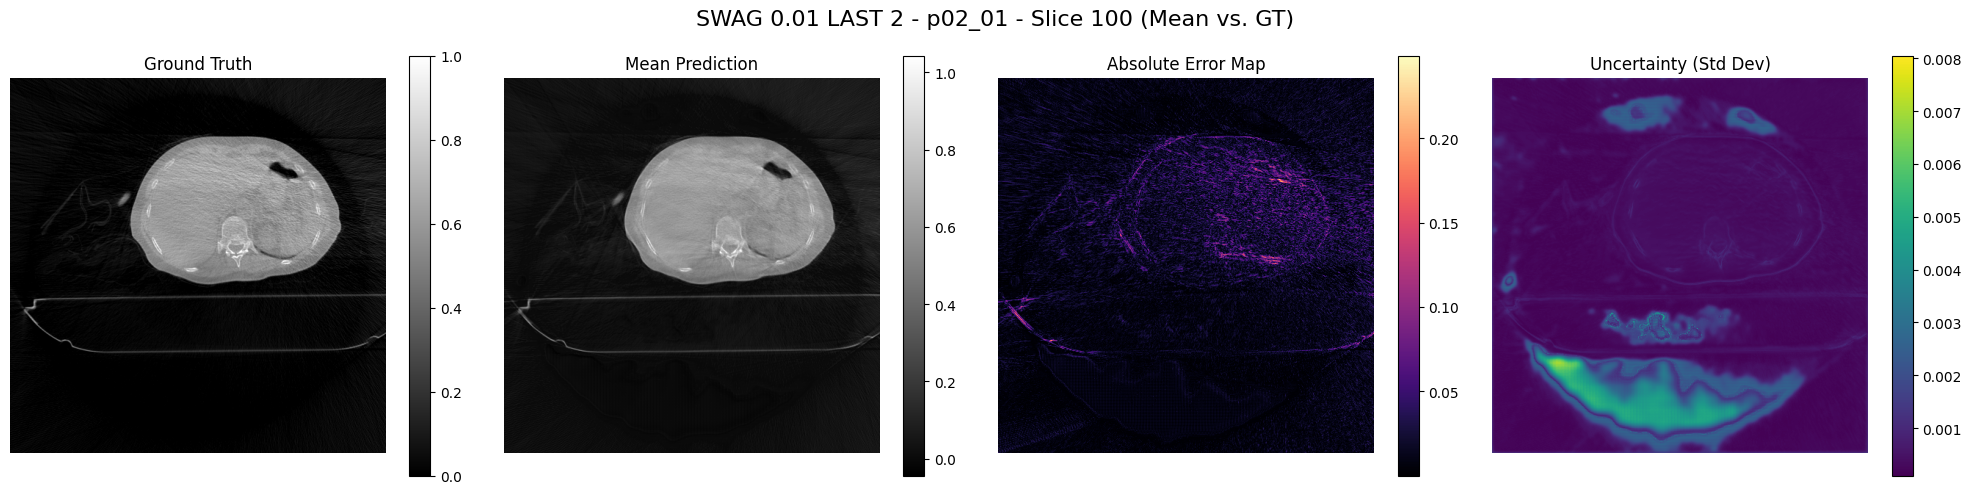

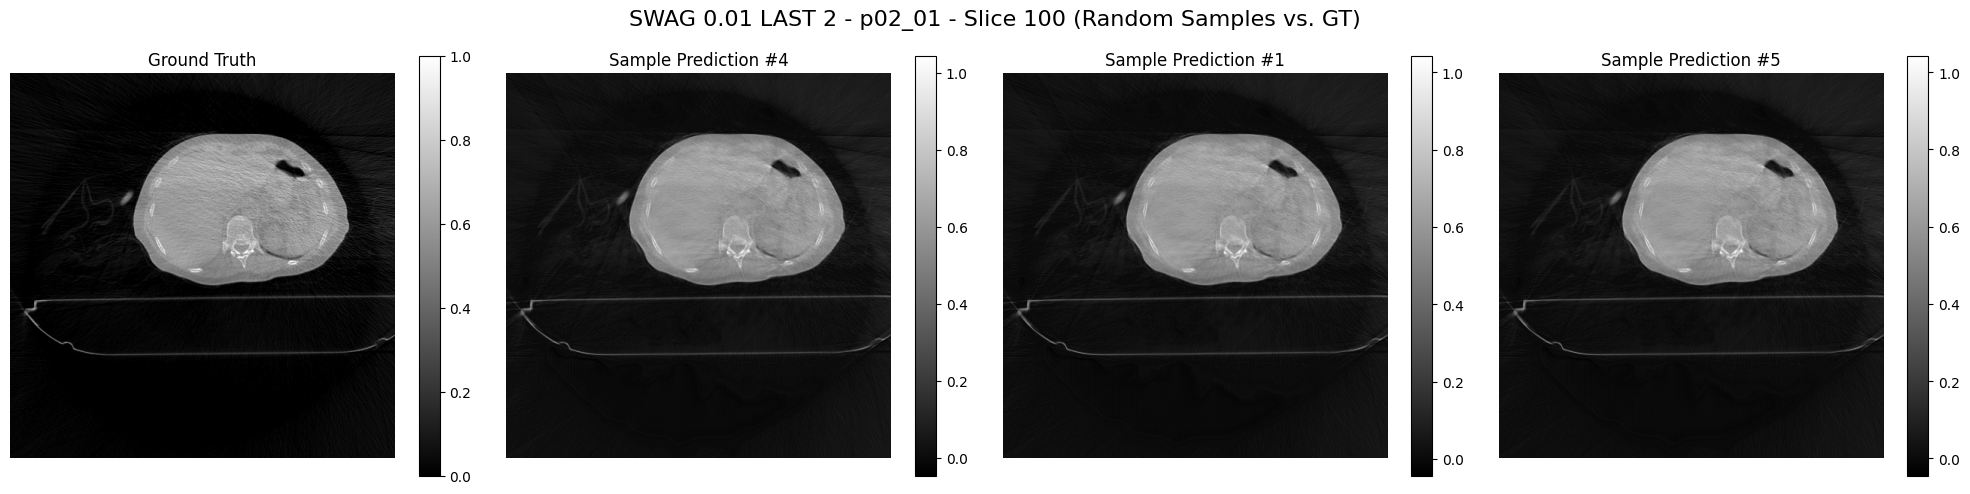

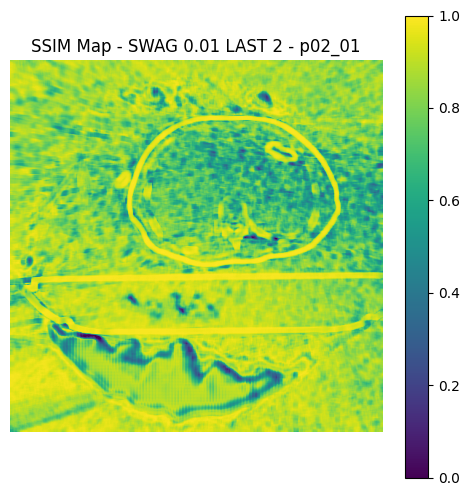

Analyzing Model: SWAG 0.01 LAST 2:  50%|█████     | 1/2 [00:09<00:09,  9.35s/it]

torch.Size([160, 512, 512]) DATA SHAPE
Loading 10 predictions for SWAG 0.01 LAST 2...


Analyzing Model: SWAG 0.01 LAST 2:  50%|█████     | 1/2 [00:09<00:09,  9.63s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'D:/NoahSilverberg/ngCBCT\\phase7\\DS13\\results\\images\\MK7_SWAG_1e-2_ONLY_LAST2\\passthrough_00\\p02_02.pt'

In [6]:
# This list will store dictionaries of results for each scan and model
all_results = []

for model_config in MODELS_TO_ANALYZE:
    model_name = model_config['name']
    domain = model_config['domain']
    
    scan_results = []

    for scan_info in tqdm(analysis_scans, desc=f"Analyzing Model: {model_name}"):
        patient, scan, _ = scan_info
        scan_name = f"p{patient}_{scan}"
        
        # --- Data Loading ---
        use_slice = SLICE_IDX if domain != 'PROJ' else None # Handle slicing
        gt = load_ground_truth(FILES, scan_info, domain, slice_idx=use_slice)
        preds = load_predictions(FILES, model_config, scan_info, slice_idx=use_slice)
        
        # --- Core Calculations ---
        gt_np = gt.cpu().numpy()
        preds_np = preds.cpu().numpy()

        mean_pred = np.mean(preds_np, axis=0)
        uncertainty_map = np.std(preds_np, axis=0)
        errors = np.abs(gt_np - mean_pred)

        # --- Metric Calculation ---
        iq_metrics, ssim_map_val = calculate_image_quality_metrics(preds, gt)
        ause_val, _ = calculate_ause(uncertainty_map, errors)
        ece_val, _, _ = calculate_ece(mean_pred, uncertainty_map, errors, n_bins=20)
        
        scan_result = {
            'model_name': model_name,
            'scan_name': scan_name,
            **iq_metrics,
            'ause': ause_val,
            'ece': ece_val
        }
        scan_results.append(scan_result)
        
        # --- Visualization ---
        print(f"\n--- Results for {model_name} on {scan_name} (Slice: {SLICE_IDX}) ---")
        plot_mean_comparison(mean_pred, gt_np, uncertainty_map, model_name, scan_name, SLICE_IDX)
        plot_sample_comparison(preds_np, gt_np, uncertainty_map, model_name, scan_name, SLICE_IDX)
        plot_ssim_map(ssim_map_val, model_name, scan_name)
        
        # Clean up memory
        del gt, preds, gt_np, preds_np, mean_pred, uncertainty_map, errors
        gc.collect()
        
    all_results.extend(scan_results)

# Convert results to a pandas DataFrame for easier analysis
results_df = pd.DataFrame(all_results)

print("\n\n✅ Analysis complete for all models and scans.")
results_df

In [ ]:
# # This list will store dictionaries of results for each scan and model
# all_results = []

# for model_config in MODELS_TO_ANALYZE:
#     model_name = model_config['name']
#     domain = model_config['domain']
    
#     scan_results = []

#     for scan_info in tqdm(analysis_scans, desc=f"Analyzing Model: {model_name}"):
#         patient, scan, _ = scan_info
#         scan_name = f"p{patient}_{scan}"
        
#         # --- Data Loading (Ground Truth Only) ---
#         # Note: We now only load the ground truth here.
#         use_slice = SLICE_IDX if domain != 'PROJ' else None
#         gt = load_ground_truth(FILES, scan_info, domain, slice_idx=use_slice)
#         gt_np = gt.cpu().numpy()
        
#         # --- Iterative Metric Calculation ---
#         # This new function replaces load_predictions and parts of the core calculations.
#         iq_metrics, ssim_map_val, mean_pred, uncertainty_map = calculate_metrics_iteratively(
#             FILES, model_config, scan_info, gt_np
#         )
        
#         # --- Uncertainty Metric Calculation ---
#         errors = np.abs(gt_np - mean_pred)
#         ause_val, _ = calculate_ause(uncertainty_map, errors)
#         ece_val, _, _ = calculate_ece(mean_pred, uncertainty_map, errors, n_bins=20)
        
#         scan_result = {
#             'model_name': model_name,
#             'scan_name': scan_name,
#             **iq_metrics,
#             'ause': ause_val,
#             'ece': ece_val
#         }
#         scan_results.append(scan_result)
        
#         # --- Visualization ---
#         print(f"\n--- Results for {model_name} on {scan_name} (Slice: {SLICE_IDX}) ---")
#         # Note: plot_sample_comparison cannot be used with this memory-saving method
#         # as it requires multiple samples at once. It can be re-enabled if needed by
#         # modifying the generator to yield a few samples for plotting.
#         plot_mean_comparison(mean_pred, gt_np, uncertainty_map, model_name, scan_name, SLICE_IDX)
#         # plot_sample_comparison(preds_np, gt_np, uncertainty_map, model_name, scan_name, SLICE_IDX)
#         plot_ssim_map(ssim_map_val, model_name, scan_name)
        
#         # Clean up memory
#         del gt, gt_np, mean_pred, uncertainty_map, errors, ssim_map_val
#         gc.collect()
        
#     all_results.extend(scan_results)

# # Convert results to a pandas DataFrame for easier analysis
# results_df = pd.DataFrame(all_results)

# print("\n\n✅ Analysis complete for all models and scans.")
# results_df

### Summary/Comparison

In [ ]:
if len(MODELS_TO_ANALYZE) > 1:
    summary_data = []
    
    # Only aggregate numeric columns
    numeric_cols = results_df.select_dtypes(include=[np.number]).columns
    summary = results_df.groupby('model_name')[numeric_cols].agg(['mean', 'std']).reset_index()

    # Prepare summary_display with formatted mean ± std for each metric
    summary_display = pd.DataFrame()
    summary_display['model_name'] = summary['model_name']
    for col in numeric_cols:
        mean_col = (col, 'mean')
        std_col = (col, 'std')
        summary_display[col] = summary[mean_col].map('{:.4f}'.format) + ' ± ' + summary[std_col].map('{:.4f}'.format)
    
    print("\n\n=======================================================")
    print("               Model Comparison Summary")
    print("=======================================================")
    
    display(summary_display)

else:
    print("\nOnly one model was analyzed. No comparison table to generate.")



               Model Comparison Summary


,model_name,mean_ssim,mean_psnr,mean_mse,mean_mae,sample_avg_ssim,sample_avg_psnr,sample_avg_mse,sample_avg_mae,ause,ece
0,SWAG 0.001,0.7075 ± 0.0235,32.3512 ± 0.6880,0.0006 ± 0.0001,0.0184 ± 0.0012,0.7031 ± 0.0224,32.3261 ± 0.6776,0.0006 ± 0.0001,0.0185 ± 0.0011,0.0180 ± 0.0001,0.0172 ± 0.0013
1,SWAG 0.01,0.8049 ± 0.0062,33.6907 ± 0.8443,0.0004 ± 0.0001,0.0144 ± 0.0011,0.7463 ± 0.0129,32.8643 ± 0.5844,0.0005 ± 0.0001,0.0165 ± 0.0009,0.0132 ± 0.0010,0.0119 ± 0.0008
2,SWAG 0.1,0.8428 ± 0.0064,33.9874 ± 0.8789,0.0004 ± 0.0001,0.0132 ± 0.0010,0.7687 ± 0.0188,31.8690 ± 0.1445,0.0007 ± 0.0001,0.0171 ± 0.0001,0.0118 ± 0.0017,0.0133 ± 0.0004
